# Usage

`liana` contains different statistical methods to infer `ligand-receptor` interactions from single-cell transcriptomics data omics data using prior knowledge.
In this notebook we showcase how to use liana in its' most basic form with toy data.

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting `SHIFT + TAB`, hit it twice to expand the view, or by typing `?name_of_function`.

</div>  

## Loading Packages

In [1]:
import liana as li

# Only needed for visualization:
import matplotlib.pyplot as plt
from scanpy.pl import umap

# toy data
from scanpy.datasets import pbmc68k_reduced

## Loading toy data

`liana` uses `anndata` objects with processed single-cell (*and soon spatial*) transcriptomics data, with pre-defined cell labels (identities), to predict ligand-receptor interactions among all pairs of cell identities.

To load the example data-set, simply run:

In [2]:
adata = pbmc68k_reduced()

The example single-cell data consists processed data with PBMCs cell types

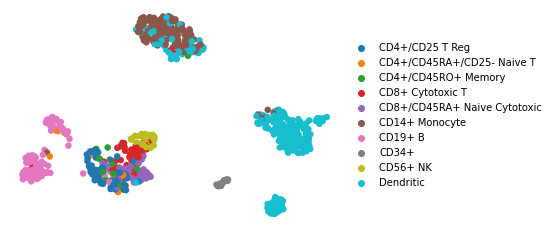

In [3]:
umap(adata, color='bulk_labels', title='', frameon=False)

## Background

In the most basic scenario, `liana` works with the log-trasformed counts matrix, in this object the normalized counts are stored in `raw`:

In [4]:
adata.raw.X

<700x765 sparse matrix of type '<class 'numpy.float32'>'
	with 174400 stored elements in Compressed Sparse Row format>

Preferably, one would use `liana` with all features (genes) for which we have enough counts, but for the sake of this tutorial we are working with a matrix pre-filtered to the variable features alone.

In the background, `liana` aggregates the counts matrix and generates statistics, typically related to cell identies.
These statistics are then utilized by each of the methods in `liana`.

### Methods

In [5]:
li.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,Consensus,magnitude_rank,specificity_rank,"Kolde, R., Laur, S., Adler, P. and Vilo, J., 2..."


Each method infers relevant ligand-receptor interactions relying on different assumptions, and each returns different ligand-receptor scores, typically a pair per method. One score corresponding to
the `magnitude` (strength) of interaction and the other reflecting how `specificity` of a given interaction to a pair cell identities.

<div class="alert alert-info">

<h4> Method Class</h4>
    
Methods in liana are **callable** instances of the `Method` class. To obtain further information for each method the user can refer to the methods documentation `?method_name` or `?method.__call__`. Alternatively, users can use the `method.describe` function to get a short summary for each method.

</div>  


For example, if the user wishes to learn more about liana's `rank_aggregate` implementation, where we combine the scores of multiple methods, they could do the following: 

In [21]:
# import liana's rank_aggregate
from liana import rank_aggregate

In [14]:
?rank_aggregate.__call__

Signature:
rank_aggregate.__call__(
    adata: anndata._core.anndata.AnnData,
    groupby: str,
    resource_name: str = 'consensus',
    expr_prop: float = 0.1,
    base: float = 2.718281828459045,
    aggregate_method='rra',
    consensus_opts=None,
    use_raw: Union[bool, NoneType] = False,
    layer: Union[str, NoneType] = None,
    de_method='t-test',
    verbose: Union[bool, NoneType] = False,
    n_perms: int = 1000,
    seed: int = 1337,
    resource: Union[pandas.core.frame.DataFrame, NoneType] = None,
) -> anndata._core.anndata.AnnData
Docstring:
Parameters
----------
adata
    Annotated data object.
groupby
    The key of the observations grouping to consider.
resource_name
    Name of the resource to be loaded and use for ligand-receptor inference.
expr_prop
    Minimum expression proportion for the ligands/receptors (and their subunits) in the
     corresponding cell identities. Set to `0`, to return unfiltered results.
base
    Exponent base used to reverse the log-trans

or alternatively:

In [15]:
rank_aggregate.describe()

Consensus uses `magnitude_rank` and `specificity_rank` as measures of expression strength and interaction specificity, respectively


#### Resources

To provide ligand-receptor predictions `liana` relies on prior-knowledge and makes use of the following ligand-receptor resources:

In [16]:
li.show_resources()

['baccin2019',
 'cellcall',
 'cellchatdb',
 'cellinker',
 'cellphonedb',
 'celltalkdb',
 'connectomedb2020',
 'consensus',
 'embrace',
 'guide2pharma',
 'hpmr',
 'icellnet',
 'italk',
 'kirouac2010',
 'lrdb',
 'ramilowski2015']

These were pre-generated using the [OmniPath](https://github.com/saezlab/omnipath) meta-database, but any custom resource can also be passed.
We refer the user to [OmniPath](https://github.com/saezlab/omnipath) as a useful tool to build any resource.

Note that `liana` uses the `consensus` resource, which is composed by multiple expert-curated ligand-receptor resources, including CellPhoneDB, CellChat, ICELLNET, connectomeDB2020, and CellTalkDB.

## Example Run

### Individual Methods

In [22]:
# import indivudla methods
from liana import cellphonedb, singlecellsignalr, natmi, connectome, logfc

In [32]:
# Run method
adata = cellphonedb(adata, groupby='bulk_labels', use_raw=True, expr_prop=0)

/home/dbdimitrov/Repos/liana-py/liana/steady/liana_pipe.py:115: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['label'] = adata.obs[groupby]
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [33]:
# by default, liana's output is saved in place:
adata.uns['liana_res'].head()

,ligand,ligand_complex,ligand_means,ligand_props,ligand_pvals,receptor,receptor_complex,receptor_means,receptor_props,receptor_pvals,source,target,lr_means,pvals
0,HLA-DRA,HLA-DRA,0.625279,0.323529,6.174542e-36,CD4,CD4,0.295691,0.220588,0.763434,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.460485,1.0
1,HLA-DQA2,HLA-DQA2,0.196956,0.117647,4.070233e-37,CD4,CD4,0.295691,0.220588,0.763434,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.246324,1.0
2,HLA-DQA1,HLA-DQA1,0.253897,0.161765,4.804243e-42,CD4,CD4,0.295691,0.220588,0.763434,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.274794,1.0
3,HLA-DRB1,HLA-DRB1,0.853603,0.382353,2.758348e-24,CD4,CD4,0.295691,0.220588,0.763434,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.574647,1.0
4,HLA-DQB1,HLA-DQB1,0.401779,0.279412,3.516375e-26,CD4,CD4,0.295691,0.220588,0.763434,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.348735,1.0


Here, we see that generic stats are provided for both `ligand_` and `receptor` *entities*, more specifically:
- `ligand` and `receptor` are typically the two entities that interact. Though it should be noted that these are not limited to secreted signalling. Also, in the case of heteromeric complexes, these represent the subunit with minimum expression, while `*_complex` corresponds to the actual complex, and is hence the unique key for each row. 
- `source` and `target` columns represent the `source/sender` and `target/receiver` cell identity for each interaction, respectively
- `*_props`: represents the proportion of cells that express the entity
- `*_pvals`: 1vsRest p-value calculated at the single-cell level
- `*_means`: entity expression mean per cell type
- `lr_means`: mean ligand-receptor expression, as a measure of ligand-receptor interaction magnutde
- `pvals`: permutation-based p-value, as a measure of interaction specificity

Note that `ligand`, `receptor`, `source`, `target` columns are returned by every method, while the rest can vary.

### Dotplot